In [1]:
import tensorflow as tf
import numpy as np
import tf_agents

from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step

import matplotlib.pyplot as plt
import pandas as pd

import random
import collections
import time
import pickle
import sys
import os

%config Completer.use_jedi = False

C:\Users\qihao\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Environment

Environment is the setup in which your agent will perform actions. Here the environment will be the tictactoe board which records the actions that the agent took. We must also make sure that the action taken was legal.
tf-agents library defines a template that aids us design an environment. 
We inherit a class call PyEnvironment and override two functions: _reset and _step
For more details: tf-environments

Action spec: The list of possible actions an agent can take (here: {x,y} co-ordinate and the player's symbol- '1' for the first player and '2' for the second one)
Observation spec: How the environment is defined. (here a 3x3 board, initialized to 0 to indicate vacant spots)

# Overriden functions:

_reset: defines how the board should look when a game begins
_step: decides how the action affects the board

PS: In competitions, this is unnecessary as kaggle provides the environment.

In [2]:
class TicTacToe(py_environment.PyEnvironment):
    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec((3,), np.int32, 0, 3, 'action')  #[x,y,symbol]
        self._observation_spec = array_spec.BoundedArraySpec(shape=(3,3), dtype=np.int32, minimum=0, name='observation') 
        self.board = np.zeros(shape=(3,3), dtype=np.int32)
        
        
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    
    def _reset(self):
        self.board = np.zeros(shape=(3,3), dtype=np.int32)
        return ts.restart(np.array(self.board))
        
    def _step(self, action):
        '''
        Rewards:
        -1 for invalid moves
        1 if you make the winning move
        0 otherwise
        '''
        
        
        index = tuple(action[:-1])
        
        if not self.inrange(index[0],index[1]) or self.board[tuple(index)] != 0:
            print("INVALID ",action)
            return ts.termination(np.array(self.board), -1)
        
        else:
            self.board[tuple(index)] = action[-1]
            if(self.check_winner(index, action[-1])):
                return ts.termination(np.array(self.board), 1)
            
            elif(self.check_draw()):
                return ts.termination(np.array(self.board), 0)
            
            else:
                return ts.transition(np.array(self.board), 0)
    
    def inrange(self, i,j):
        if 0<=i<=2 and 0<=j<=2:
            return True
        return False

    def check_winner(self, index, player):
        '''
        Utility function to check if the current move is a winning move
        index: (x,y) coordinates of the current move
        player: [1|2] symbol of the player who made the current move
        '''
        x,y = index[0],index[1]
        
        for i in [-1,0,1]:    #for all neighbours of current move
            for j in [-1,0,1]:
                if i==j==0:    #except itself
                    continue
        
                if self.inrange(x+i,y+j):
                    if self.board[(x+i,y+j)] == player:    #has the same symbol
                        
                        if self.inrange(x+i*2,y+j*2):    #check along the same direction(when you are starting from corners)
                            if self.board[(x+i*2,y+j*2)] == player:
                                return True
                            
                        
                        if self.inrange(x-i,y-j):    #check the other direction(when you are starting from middle)
                            if self.board[(x-i,y-j)] == player:
                                return True
        
        return False
    
    
    def check_draw(self): 
        '''
        Utility function to check if the game ended in a draw
        Note: check for draw only after checking for a winner
        '''
        for i in [0,1,2]:
            for j in [0,1,2]:
                if self.board[(i,j)]==0:
                    return False
        
        return True
    
    
    def display(self):
        print(self.board)

# GYM
Gym is a wrapper around the environment. This is necessary in a 2 player environment to simulate the second player. It takes an agent as argument which will be used to choose the opponent's action.
Any of the agents can be plugged into the gym to train against.

Gym encapsulates the env object and handles all interactions between the player agent and the env appropriately.

Usage is described in the class

PS: in competitions, this is unnecessary

In [3]:
class GymTTT():
    """
    It is a wrapper around the tictactoe env.
    It takes an agent as argument which will be used to choose the action
    
    Arguments:
        agent: instance of an agent
        verbose: [True|False] want messages printed to console output?
    
    Usage:
        gym = GymTTT(Agent(),True)
    """
    
    
    
    
    def __init__(self, agent, verbose = False):
        self.agent = agent
        self.env = TicTacToe()
        self.verbose = verbose
    
    def reset(self):
        if self.agent.symbol == 1:    #if gym's agent has to start, then make the first move
            timeStep = self.env.reset()
            policyStep = self.agent.action(timeStep)
            timeStep = self.env.step(policyStep.action)
            timeStep = timeStep._replace(reward = timeStep.reward * -1)    #invert reward
            
            
            self.print_message("\n********GYM STARTS********")
            self.print_message("GYM Agent Move: "+str(policyStep.action[:2]))
            self.fancy_display(timeStep.observation)
            return timeStep
        
        else:
            self.print_message("\n********PLAYER STARTS********")    
            return self.env.reset()
    
    
    def step(self, action):
            
        #player's move
        timeStep = self.env.step(action)
        self.print_message("Player Move: "+str(action[:2]))
        self.fancy_display(timeStep.observation)

        #if player's move was last
        if timeStep.is_last():
            if timeStep.reward==0:
                self.print_message("***Game Over: Draw***")
            elif timeStep.reward==-1:
                self.print_message("***Invalid move: Gym Agent Wins")
            else:
                self.print_message("*** Yay!: Test Agent Wins ***")
            
            return timeStep
        
        else:
            #agent's move
            policyStep = self.agent.action(timeStep)
            timeStep = self.env.step(policyStep.action)
            timeStep = timeStep._replace(reward = timeStep.reward * -1)    #invert agent's reward for player
            
            self.print_message("GYM Agent Move: "+str(policyStep.action[:2]))
            self.fancy_display(timeStep.observation)
            
            if timeStep.is_last():
                if timeStep.reward==0:
                    self.print_message("***Game Over: Draw***")
                else:
                    self.print_message("***Yay!: Gym Agent Wins ***")
            
            return timeStep
            
    
    def print_message(self,message):
        if self.verbose:
            print(message)
        
        
    def fancy_display(self,board,action=[-1,-1]):
        #array representation was good enough
        if self.verbose:
            print(board)

# Agent

An agent needs to evaluate the current observation and choose a legal action For uniformity, in this notebook, all agents have a function called action which accepts a timestep as argument and returns a PolicyStep.

For more info on the datatypes check out:
tf_agents.trajectories.TimeStep
tf_agents.trajectories.PolicyStep

An agent needs the player symbol as argument. For simplicity we use 1 and 2 to represent the First and the Second player

To start with a simple agent, we can have it choose randomly from a list of empty slots

In [4]:
class RandomTTTAgent():
    """
         Arguments:
            symbol: [1|2] - player symbol
        Usage:
            Agent =  RandomTTTAgent(1) # Plays first
            
    """
    def __init__(self,symbol):
        self.symbol = symbol
        self.trainable = False
        
    def action(self, timestep):
        board = timestep.observation
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
        
        choice = random.choice(empty_slots)
        return tf_agents.trajectories.PolicyStep(action=choice+[self.symbol], state = board, info=self.symbol)

# MiniMax

Here we implement an agent that chooses the best action by playing out all possible scenarios.
For a theoretical understanding, check out Minimax Algorithm (a traditional backtracking algorithm).

In Brief, It builds a tree of all possible actions from the current state and picks the one that fetches the highest reward. To calculate the reward, it simulates the game and plays along all possible sequences. In the simulation, it tries to maximise the reward obatained in its turn and minimise the reward obtained in the opponent's turn.

In [5]:
class MinMaxAgent():    #builds a minmax tree
    
    """
     Arguments:
            symbol: [1|2] - player symbol
            verbose: (optional) [True|False] - want messages printed to console output?
            
        Usage:
            Agent =  MinMaxAgent(2, True) -- plays first and prints debug messages
            
    """
    
    def __init__(self, symbol, verbose=False):
        self.symbol = symbol
        self.verbose = verbose
        self.trainable = False
        
    def action(self, timeStep):
        board = np.array(timeStep.observation)
        
        act = self.getBestAction(np.array(board))
        
        return tf_agents.trajectories.PolicyStep(action = list(act)+[self.symbol], state = board, info = self.symbol)
    
    
    def getBestAction(self,board):
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
    
        best_score = -100
        act = ()
        temp_board = np.array(board)
        if self.verbose:
            print("MinMax Says:")
        for [i,j] in empty_slots:
            temp_board[(i,j)] = self.symbol
            score = self.minmax(np.array(temp_board), 0, False, (i,j,self.symbol))
            if self.verbose:
                print(i,j,score)
            if score>best_score:
                best_score = score
                act = (i,j)
            temp_board[(i,j)] = 0
            
        return act
    
    
    def minmax(self, board, depth, maximise, last_move):
        '''
            MinMax tree: Alternate between your and opponent's move. 
            In your move you'll pick the maximising choice; In the opponents move pick the minimising choice(which is his maximum)
            Here: 
                A winning move gets 10 points
                A losing move gets -10 points
                A drawn board gets 0
                All intermediate moves gets (finalScore - numberOfStepsLeft)
            Imagine a tree with leaf nodes having 0/10/-10 and with each level above gets max or min of all its branches depending on the level
        '''

        if self.check_winner(board,last_move):
            if last_move[-1] == self.symbol:
                return 10 
            else:
                return -10 
             
        if self.check_draw(board): #check draw only after checking for winners
            return 0
           
        
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
                    
        temp_board = np.array(board)
        
        if maximise:
            best_val = -100
            for (i,j) in empty_slots:
                player = 3 - last_move[-1]    #switch b/w 1 and 2
                
                temp_board[(i,j)] = player    #pick one of the empty spots
                
                best_val = max(self.minmax(np.array(temp_board), depth+1, not maximise, (i,j,player)),best_val)

                temp_board[(i,j)] = 0    #clear the picked empty spot
                
        else:
            best_val = 100
            for (i,j) in empty_slots:
                player = 3 - last_move[-1]
                temp_board[(i,j)] = player
                
                best_val = min(self.minmax(np.array(temp_board), depth+1, not maximise, (i,j,player)), best_val)
                
                temp_board[(i,j)] = 0
        
        return best_val
        
            
    
    def check_draw(self,board):
        board = np.array(board)
        for i in [0,1,2]:
            for j in [0,1,2]:
                if board[(i,j)]==0:
                    return False
        
        return True
    
    
    def check_winner(self, board, last_move):
        board = np.array(board)
        x,y,player = last_move[0],last_move[1],last_move[2]
        
        for i in [-1,0,1]:    #for all neighbours of current move
            for j in [-1,0,1]:
                if i==j==0:    #except itself
                    continue
        
                if self.inrange(x+i,y+j):
                    if board[(x+i,y+j)] == player:    #has the same symbol
                        
                        if self.inrange(x+i*2,y+j*2):    #check along the same direction(when you are starting from corners)
                            if board[(x+i*2,y+j*2)] == player:
                                return True
                            
                        
                        if self.inrange(x-i,y-j):    #check the other direction(when you are starting from middle)
                            if board[(x-i,y-j)] == player:
                                return True
        
        return False
    
    def inrange(self, i,j):
        if 0<=i<=2 and 0<=j<=2:
            return True
        return False

You may have noticed, minimax algorithm builds a tree in each step even though they are just subtrees of the first computed tree. This excess computation can be avoided by storing the obtained rewards which significantly reduces the compute time of the algorithm.

In [6]:
class DPMinMaxAgent():    #minmax takes for ever, so memoize it
    '''
        Here we use a dictionary to store the rewards, where board is the key and its minmax score is its value.
        Arguments:
            symbol: [1|2] - player symbol
            verbose: [True|False] - want messages printed to console output?
            saveTree: [True|False] - save the constructed tree dict into a file?
            loadTree: [True|False] - load a previously constructed tree dict from memory?
            saveTreeFreq: if saveTree is True, save the tree into memory once every 'x' updates. This is coded to decrease over time.
            
        Usage:
            Agent = DPMinMaxAgent(2) -- plays second, doesn't save or load from memory
            Agent = DPMinMaxAgent(1, verbose=True, saveTree=False, loadTree=True) -- to load from memory but not save it.
            
    '''
    def __init__(self, symbol, verbose=False, saveTree=False, loadTree=False, saveTreeFreq=100):
        self.symbol = symbol
        self.verbose = verbose
        self.trainable = False
        
        self.saveTreeFreq = saveTreeFreq
        self.saveTreeFreqStart = saveTreeFreq    # high val would mean a lot of them won't be saved; low value would update too many times, so decrease freq periodically
        self.saveTree = saveTree
        self.pickle_loaded = False
        if loadTree:
            try:
                with open("/kaggle/working/minmaxtree.pickle","rb") as f:
                    self.tree = pickle.load(f)
                    self.pickle_loaded = True
            except Exception as e:
                self.pickle_loaded = False
                print(e)
                loadTree = False
            
        if not self.pickle_loaded:
            self.tree = {}
     
        
    def action(self, timeStep):
        board = np.array(timeStep.observation)
        
        act = self.getBestAction(np.array(board))
        
        return tf_agents.trajectories.PolicyStep(action = list(act)+[self.symbol], state = board, info = self.symbol)
    
    
    def getBestAction(self,board):
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
    
        best_score = -100
        act = ()
        temp_board = np.array(board)
        
        if self.verbose:
            print("MinMax Says:")
            
        for [i,j] in empty_slots:
            temp_board[(i,j)] = self.symbol
            score = self.minmax(temp_board, 0, False, (i,j,self.symbol))
            if self.verbose:
                print(i,j,score)
            if score>best_score:
                best_score = score
                act = (i,j)
            temp_board[(i,j)] = 0
            
        return act
    
    
    def minmax(self, board, depth, maximise, last_move):
        last_move = list(last_move)
        
        if self.tree.get(board.tobytes()):    #check dict and return value if it already exists
            return self.tree.get(board.tobytes())
        
        
        if self.check_winner(board,last_move):
            if last_move[-1] == self.symbol:
                return 20
            else:
                return -20
             
        if self.check_draw(board):
            return 0
        
            
        
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
                    
        temp_board = np.array(board)
        
        if maximise:
            best_val = -100
            for (i,j) in empty_slots:
                player = 3 - last_move[-1]
                
                temp_board[(i,j)] = player                
                temp_board_value = self.oneLess(self.minmax(np.array(temp_board), depth+1, not maximise, (i,j,player)))
                if not self.tree.get(temp_board.tobytes()):    #store value if not exists
                    self.tree[temp_board.tobytes()] = temp_board_value
                    self.saveTreeFreq -= 1
                
                best_val = max(temp_board_value,best_val)
                temp_board[(i,j)] = 0
                
        else:
            best_val = 100
            for (i,j) in empty_slots:
                player = 3 - last_move[-1]
                
                temp_board[(i,j)] = player
                temp_board_value = self.oneLess(self.minmax(np.array(temp_board), depth+1, not maximise, (i,j,player)))
                if not self.tree.get(temp_board.tobytes()):
                    self.tree[temp_board.tobytes()] = temp_board_value
                    self.saveTreeFreq -= 1
                
                best_val = min(temp_board_value, best_val)
                temp_board[(i,j)] = 0
        
        
        if self.saveTree and self.saveTreeFreq==0:
            with open("/kaggle/working/minmaxtree.pickle","wb") as f:
                pickle.dump(self.tree, f)
                self.saveTreeFreq = self.saveTreeFreqStart
                self.saveTreeFreqStart -= 1    # n*(n-1)/2 updates
        
        return best_val
        
        
    def oneLess(self,x):
        if x>0:
            return x-1
        elif x< 0:
            return x+1
        else:
            return 0
            
    
    def check_draw(self,board):
        board = np.array(board)
        for i in [0,1,2]:
            for j in [0,1,2]:
                if board[(i,j)]==0:
                    return False
        
        return True
    
    
    def check_winner(self, board, last_move):
        board = np.array(board)
        x,y,player = last_move[0],last_move[1],last_move[2]
        
        for i in [-1,0,1]:    #for all neighbours of current move
            for j in [-1,0,1]:
                if i==j==0:    #except itself
                    continue
        
                if self.inrange(x+i,y+j):
                    if board[(x+i,y+j)] == player:    #has the same symbol
                        
                        if self.inrange(x+i*2,y+j*2):    #check along the same direction(when you are starting from corners)
                            if board[(x+i*2,y+j*2)] == player:
                                return True
                            
                        
                        if self.inrange(x-i,y-j):    #check the other direction(when you are starting from middle)
                            if board[(x-i,y-j)] == player:
                                return True
        
        return False
    
    def inrange(self, i,j):
        if 0<=i<=2 and 0<=j<=2:
            return True
        return False

Let us test out the minimax agent against the random agent

In [7]:
t = time.time()

TestAgent = DPMinMaxAgent(1)    #Agent 1
gymAgent = RandomTTTAgent(2)    #Agent 2

gym = GymTTT(gymAgent,True)

timeStep = gym.reset()  

while not timeStep.is_last():
    timeStep = gym.step(TestAgent.action(timeStep).action)

print(time.time() - t)


********PLAYER STARTS********
Player Move: [0, 0]
[[1 0 0]
 [0 0 0]
 [0 0 0]]
GYM Agent Move: [1, 0]
[[1 0 0]
 [2 0 0]
 [0 0 0]]
Player Move: [0, 1]
[[1 1 0]
 [2 0 0]
 [0 0 0]]
GYM Agent Move: [1, 2]
[[1 1 0]
 [2 0 2]
 [0 0 0]]
Player Move: [0, 2]
[[1 1 1]
 [2 0 2]
 [0 0 0]]
*** Yay!: Test Agent Wins ***
0.47618532180786133


In order to evaluate an agent, its best to play against it yourself. So use a Human agent if you want to play against one of the other agents.

In [8]:
class HumanTTTAgent():    #for humans vs machine
    def __init__(self, symbol, verbose=False):
        self.symbol= symbol
        self.verbose = verbose
        self.trainable = False
        
    
    def action(self, timeStep):
        board = timeStep.observation
        
        empty_slots = []
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
        
        print(board)
        print("input space seperated indices; choose from the empty slots")
        print("EmptySlots: ",empty_slots)
        i,j = self.get_inputs()
        tries = 2
        while [i,j] not in empty_slots and tries:
            print("invalid choice, input space seperated indices, tries left: ",tries)
            i,j = self.get_inputs()
            tries -= 1
        
        if not tries:
            print("Illiterate")
            
        act = [i,j,self.symbol]
        return tf_agents.trajectories.PolicyStep(action = act, state = board, info = self.symbol)
    
    def get_inputs(self):
        try:
            i,j = [int(x) for x in input().split()]
            return (i,j)
        except:
            return (9,9)
        
    def updateActionValue(self, qtuple):
        pass

In [9]:
#Use this as a template to play around with the agents

t = time.time()

TestAgent =  DPMinMaxAgent(1)   #Agent 1
gymAgent = HumanTTTAgent(2)    #Agent 2

gym = GymTTT(gymAgent,True)

timeStep = gym.reset()  

while not timeStep.is_last():
    timeStep = gym.step(TestAgent.action(timeStep).action)

print(time.time() - t)



********PLAYER STARTS********
Player Move: [0, 0]
[[1 0 0]
 [0 0 0]
 [0 0 0]]
[[1 0 0]
 [0 0 0]
 [0 0 0]]
input space seperated indices; choose from the empty slots
EmptySlots:  [[0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]


 1 1


GYM Agent Move: [1, 1]
[[1 0 0]
 [0 2 0]
 [0 0 0]]
Player Move: [0, 1]
[[1 1 0]
 [0 2 0]
 [0 0 0]]
[[1 1 0]
 [0 2 0]
 [0 0 0]]
input space seperated indices; choose from the empty slots
EmptySlots:  [[0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 2]]


 0 2


GYM Agent Move: [0, 2]
[[1 1 2]
 [0 2 0]
 [0 0 0]]
Player Move: [2, 0]
[[1 1 2]
 [0 2 0]
 [1 0 0]]
[[1 1 2]
 [0 2 0]
 [1 0 0]]
input space seperated indices; choose from the empty slots
EmptySlots:  [[1, 0], [1, 2], [2, 1], [2, 2]]


 1 0


GYM Agent Move: [1, 0]
[[1 1 2]
 [2 2 0]
 [1 0 0]]
Player Move: [1, 2]
[[1 1 2]
 [2 2 1]
 [1 0 0]]
[[1 1 2]
 [2 2 1]
 [1 0 0]]
input space seperated indices; choose from the empty slots
EmptySlots:  [[2, 1], [2, 2]]


 2 2


GYM Agent Move: [2, 2]
[[1 1 2]
 [2 2 1]
 [1 0 2]]
Player Move: [2, 1]
[[1 1 2]
 [2 2 1]
 [1 1 2]]
***Game Over: Draw***
47.672285318374634


# Q-Learning

Here we implement an agent which uses Q-learning to choose actions. Its a classic reinforcement technique that determines the action based on its past experiences.
For a structured theoretical understanding please refer to Suton and Barto.
In brief, it relies on its experience to determine how good is an action at a certain stage of the game, which is quantified by reward. For each step of the game, we store the reward obtained and this value is corrected each time we visit this state using the q-learning formula:

Then we pick the action which has the highest reward associated with it, the next time we are in the same state. Here we use a dictionary to store and update these action values. Since this involves training, I have already attached a trained dictionary which can optionally be loaded by setting the load_av argument to true.

In [10]:
class QLearningAgent():
    def __init__(self, symbol, trainable = True, alpha = 0.1, gamma =1, load_av = False, save_av = False, saveAVFreq = 100):
        '''
        Action values: Dictionary with board as index and a dictionary of {state:{action:reward}} as values
        
        Arguments:
            symbol: [1|2] - player symbol
            trainable: [True|False] - should we use the current game for training?
            alpha: learning rate
            gamma: discount rate
            load_av: [True|False] - load a previously trained dict from memory?
            save_av: [True|False] - save action values into memory?
            saveAVFreq: save action values after these many updates
            
        Usage:
            Agent = QLearningAgent(2) -- plays second, doesn't save or load from memory
            Agent = QLearningAgent(1, save_av=False, load_av=True) -- load trained data from memory but don't save any updates.
            Agent = QLearningAgent(1, alpha=0.3, gamma=0.9) 
        
        '''
        self.symbol = symbol
        self.trainable = trainable
        self.alpha = alpha
        self.gamma = gamma
        
        self.saveAVFreq = saveAVFreq
        self.save_av = save_av
        self.pickle_loaded = False
        if load_av:
            try:
                with open("/kaggle/working/av.pickle","rb") as f:
                    self.av = pickle.load(f)
                    self.pickle_loaded = True
            except Exception as e:
                self.pickle_loaded = False
                print(e)
                load_av = False
            
        if not self.pickle_loaded:
            self.av = collections.defaultdict(self.module_default_dict)
     
    
    def module_default_dict(self):    #pickle cant save lambdas
        return collections.defaultdict(int)
        
    def updateActionValue(self, qtuple):
        '''
            qtuple holds: 
                current state: board - 3x3 array
                action taken: indices - [i,j]
                reward obtained
                next state: board - 3x3 array
        '''
        
        current = qtuple['cur'].tobytes() #serialize it
        action = qtuple['act'] if len(qtuple['act']) == 2 else qtuple['act'][:2]
        reward = qtuple['rew']
        nextState = qtuple['nex'].tobytes()
        
        qmax = max(self.av[(nextState,self.symbol)].values()) if self.av[(nextState,self.symbol)].values() else 0    #if next_state is not present in av, then return 0
        self.av[(current,self.symbol)][tuple(action)] += self.alpha * (reward + self.gamma * qmax - self.av[(current,self.symbol)][tuple(action)])
        
        self.saveAVFreq -= 1
        if self.save_av and self.saveAVFreq == 0:
            with open("/kaggle/working/av.pickle","wb") as f:
                pickle.dump(self.av, f)
            self.saveAVFreq = 100
        
    
    def action(self, timeStep):
        board = timeStep.observation
        qsa = dict(self.av[(board.tobytes(),self.symbol)])
        # print(qsa)
        
        was_random_choice = False
        empty_slots = []    #find the list of actions possible
        for i in range(0,3):
            for j in range(0,3):
                if board[(i,j)] == 0:
                    empty_slots.append([i,j])
        
        while qsa and max(qsa.values())>=0:  #choose from the existing options only if it has a non -ve value
            act = max(qsa, key=qsa.get) 
            if board[tuple(act)] ==0:
                break
            qsa.pop(act,None)
        
        else:
            was_random_choice = True
            act = random.choice(empty_slots)    #else chose randomly
                
            
        return tf_agents.trajectories.PolicyStep(action=list(act) + [self.symbol], state = board, info=was_random_choice)
        
        
    def displayAV(self):
        print("***AV***")
        for k,v in dict(self.av).items():
            board = np.ndarray((3,3), np.int32, k[0])
            print(board,k[1])
            print(v)

In [11]:
#Sanity test against a random agent
t = time.time()

TestAgent = QLearningAgent(1)    #Agent 1
gymAgent = RandomTTTAgent(2)    #Agent 2

gym = GymTTT(gymAgent,True)

timeStep = gym.reset()  

while not timeStep.is_last():
    timeStep = gym.step(TestAgent.action(timeStep).action)

print(time.time() - t)


********PLAYER STARTS********
Player Move: [1, 2]
[[0 0 0]
 [0 0 1]
 [0 0 0]]
GYM Agent Move: [1, 1]
[[0 0 0]
 [0 2 1]
 [0 0 0]]
Player Move: [2, 2]
[[0 0 0]
 [0 2 1]
 [0 0 1]]
GYM Agent Move: [2, 1]
[[0 0 0]
 [0 2 1]
 [0 2 1]]
Player Move: [0, 1]
[[0 1 0]
 [0 2 1]
 [0 2 1]]
GYM Agent Move: [2, 0]
[[0 1 0]
 [0 2 1]
 [2 2 1]]
Player Move: [0, 0]
[[1 1 0]
 [0 2 1]
 [2 2 1]]
GYM Agent Move: [0, 2]
[[1 1 2]
 [0 2 1]
 [2 2 1]]
***Yay!: Gym Agent Wins ***
0.0020155906677246094


An untrained Q-learning agent would pick random actions. With each game, it learns to differentiate good moves from bad ones. So let us train our agent.
As we train, it is imperitive to collect your game results as well. Its the best metric to track the training.
As I had mentioned earlier, the q-learning agent makes a random choice when it hasn't seen the current state before, hence measuring the number of random actions vs choosen actions could also serve as a metric to track the training levels.
We can choose any of the agents(including itself) as the opponent.

Note: The agent must be trained as both First Player and Second Player

In [12]:
#stats
results = []
random_actions = []

In [13]:
# initialize the agent to be train
TestAgent = QLearningAgent(1)

In [14]:
#initialize gym
gymAgent = RandomTTTAgent(2)
gym = GymTTT(gymAgent,False)

In [15]:
start = time.time()
games = 1000    #episodes
for i in range(games):
    timeStep = gym.reset()
    random_action_count = 0
    while not timeStep.is_last():
        policyStep = TestAgent.action(timeStep)
        nexTimeStep = gym.step(policyStep.action)
        
        if (policyStep.info):
            random_action_count+=1
            
        qtuple = {}
        qtuple['cur'] = timeStep.observation
        qtuple['act'] = policyStep.action[:2]
        qtuple['rew'] = nexTimeStep.reward
        qtuple['nex'] = nexTimeStep.observation
        
        if TestAgent.trainable:
            TestAgent.updateActionValue(qtuple)

        timeStep = nexTimeStep
    
    results.append(int(timeStep.reward))    #collect stats
    random_actions.append(random_action_count)
    
    
print(len(results))
print(time.time() - start)
print("Win Percentage: ",results[-games:].count(1)/games)    #stats for last x games
print("Draw Percentage: ",results[-games:].count(0)/games)
print("Loss Percentage: ",results[-games:].count(-1)/games)

1000
0.7210104465484619
Win Percentage:  0.744
Draw Percentage:  0.112
Loss Percentage:  0.144


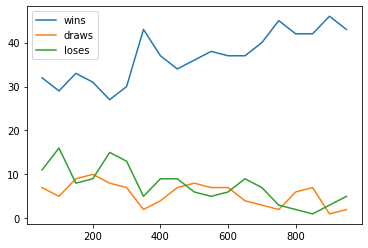

In [16]:
freq = 50    #bucket-size for plotting higher sizes give smoother curves

a,b = 0, len(results)    #range to plot; (change a to len(results)-x to plot only the last x)

metrics = collections.defaultdict(list)

for i in range(a, b, freq):
    if i==0:
        continue
    
    metrics['games'].append(i)
    metrics['wins'].append(results[i-freq:i].count(1))
    metrics['draws'].append(results[i-freq:i].count(0))
    metrics['loses'].append(results[i-freq:i].count(-1))
    metrics['win_pct'].append(results[i-freq:i].count(1)/float(freq))

metrics['randomness'] = [sum(random_actions[i-freq:i]) for i in range(a, b,freq) if i!=0] #how many of the actions were just random(by a q agent)
        


plt.plot(metrics['games'], metrics['wins'], label='wins')
# plt.plot(metrics['games'], metrics['win_pct'], label='wins_pct')
plt.plot(metrics['games'], metrics['draws'], label='draws')
plt.plot(metrics['games'], metrics['loses'], label='loses')
# plt.plot(metrics['games'], metrics['randomness'], label='randomness')
plt.legend(loc = 0)
plt.show()